# Region simulation tutorial


A basic simulation consists of five main components, each of these components is an object within TVB:

- Model, which is, at its core, a set of differential equations describing the local neuronal dynamics;
- Connectivity, represents the large scale structural connectivity of the brain, ie white-matter tracts;
- Coupling, is a function that is used to join the local Model dynamics at distinct locations over the connections described in Connectivity;
- Integrator, is the integration scheme that will be applied to the coupled set of differential equations;
- Monitors, one or more Monitors can be attached to a simulation, they act to record the output from the Simulator.

All of these components are brought together in a Simulator object, which is then used to run a simulation.

Sketched from: https://github.com/the-virtual-brain/tvb-root/blob/master/tvb_documentation/tutorials/tutorial_s1_region_simulation.ipynb

For others tutorials: https://github.com/the-virtual-brain/tvb-root/tree/master/tvb_documentation/tutorials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tvb.simulator.lab import *
"""
 pip install tvb-library
 pip install tvb-framework
 https://github.com/the-virtual-brain/tvb-root/tree/master
"""

'\n pip install tvb-library\n pip install tvb-framework\n https://github.com/the-virtual-brain/tvb-root/tree/master\n'

## model

In [2]:
oscillator = models.Generic2dOscillator()
#oscillator = models.JansenRit() # have a look to notebook JensenRit_et_al_1995 in brian2 folder

# models.Hopfield
# models.Generic2dOscillator()

## connectivity

In [3]:
conn = connectivity.Connectivity.from_file()

conn.speed = np.array([4.0])


2024-11-28 19:40:45,385 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [15]:
conn.delays

array([[ 0.        ,  5.082518  ,  8.21900725, ..., 22.40630825,
        24.53385675,  0.        ],
       [ 5.082518  ,  0.        , 11.6557605 , ..., 23.76068325,
        26.970695  ,  0.        ],
       [ 8.21900725, 11.6557605 ,  0.        , ..., 22.32615075,
        22.498525  ,  0.        ],
       ...,
       [22.40630825, 23.76068325, 22.32615075, ...,  0.        ,
         6.822921  ,  0.        ],
       [24.53385675, 26.970695  , 22.498525  , ...,  6.822921  ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

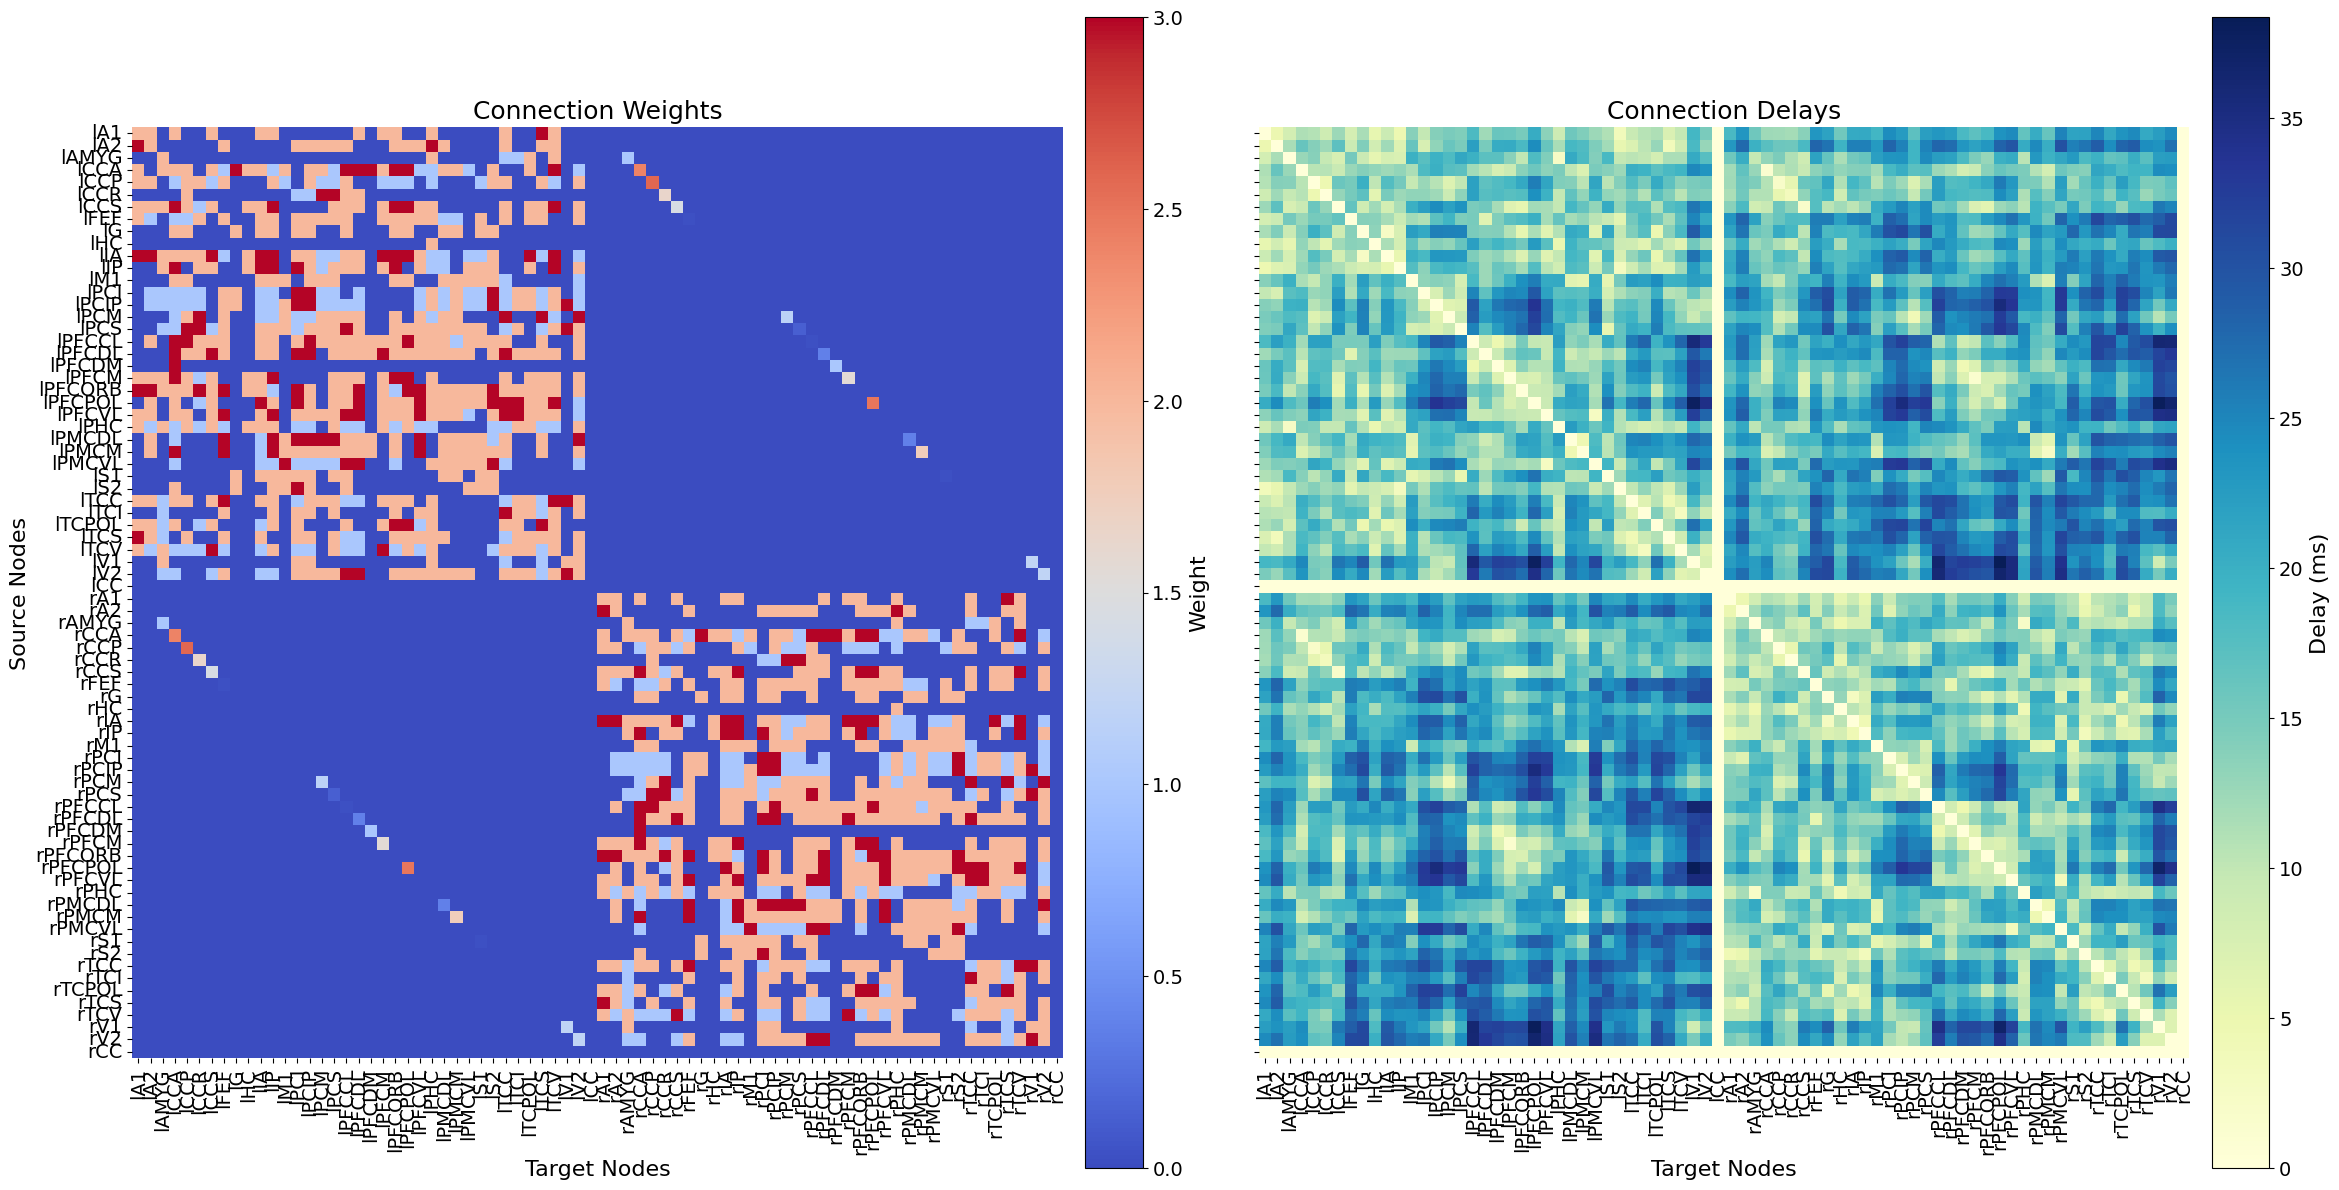

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12), sharex=True, sharey=True)
weight_plot = sns.heatmap(
    conn.weights,
    ax=ax[0],
    xticklabels=conn.ordered_labels,
    yticklabels=conn.ordered_labels,
    cmap="coolwarm",
    cbar=False,  
    annot=False,
    square=True
)
cbar_weights = fig.colorbar(weight_plot.get_children()[0], ax=ax[0], orientation='vertical', pad=0.02)
cbar_weights.set_label("Weight", fontsize=16)
cbar_weights.ax.tick_params(labelsize=14)
ax[0].set_title("Connection Weights", fontsize=18)
ax[0].set_xlabel("Target Nodes", fontsize=16)
ax[0].set_ylabel("Source Nodes", fontsize=16)
ax[0].tick_params(labelsize=14)
delay_plot = sns.heatmap(
    conn.delays,
    ax=ax[1],
    xticklabels=conn.ordered_labels,
    yticklabels=conn.ordered_labels,
    cmap="YlGnBu",
    cbar=False,  
    annot=False,
    square=True
)
cbar_delays = fig.colorbar(delay_plot.get_children()[0], ax=ax[1], orientation='vertical', pad=0.02)
cbar_delays.set_label("Delay (ms)", fontsize=16)
cbar_delays.ax.tick_params(labelsize=14)
ax[1].set_title("Connection Delays", fontsize=18)
ax[1].set_xlabel("Target Nodes", fontsize=16)
ax[1].tick_params(labelsize=14)
plt.tight_layout()


## coupling

In [5]:
conn_coupling = coupling.Linear(a=np.array([0.0154]))

## thalamic stimulation

In [6]:
do_stim=True
if do_stim:
    conn.configure()
    nodes = [10, 50] # e.g., [35, 36] # V1 and V2 
    stim_weights = np.zeros((conn.number_of_regions, 1))
    k = .1
    stim_weights[nodes] = np.array([1*k, 0.0])[:, np.newaxis] # il weight of roi50 is set to 0
    eqn_t = equations.PulseTrain()
    eqn_t.parameters["onset"] = 100.0 # ms
    eqn_t.parameters["tau"]   = 1 # 5 ms
    eqn_t.parameters["T"]     = 1*k # 500 -> 0.002kHz repetition frequency

    stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                      connectivity = conn, 
                                      weight = stim_weights)
else:
    stimulus = None

## integrator

In [7]:
h = 1 #ms
heunint = integrators.HeunDeterministic(dt=h) #, noise=noise.Additive(nsig = numpy.array([0.015]))


## monitors

In [8]:
#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=h*50)

#Bundle them
recordings = (mon_raw, mon_tavg)

#monitors.MEG()
#monitors.Bold()
#monitors.EEG(projection=projections.ProjectionSurfaceEEG.from_file(), 
#             sensors=sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt"), 
#             region_mapping=region_mapping.RegionMapping.from_file(), 
#             period=1e3/2048.))


## simulator

In [9]:
#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = conn,
                          coupling = conn_coupling, 
                          integrator = heunint, 
                          stimulus = stimulus,
                          monitors = recordings)

sim.configure()

## run 

In [10]:
#Perform the simulation

raw_data = []
raw_time = []
tavg_data = []
tavg_time = []
k = 10
bioTime = 250*k #ms
for raw, tavg in sim(simulation_length=bioTime):
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

2024-11-28 19:40:46,008 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


## results

In [11]:
#Make the lists numpy.arrays for easier use.
RAW = np.array(raw_data)
TAVG = np.array(tavg_data)

Text(0.5, 1.0, 'Temporal average')

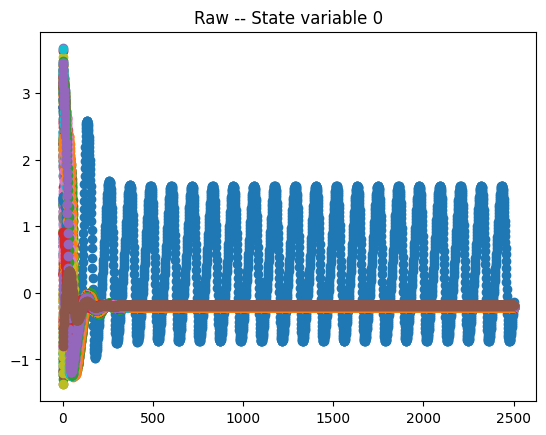

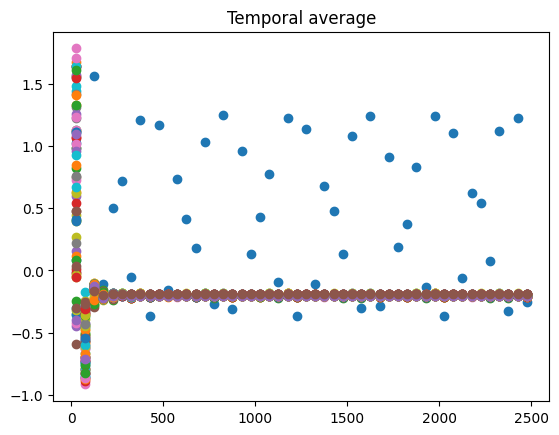

In [12]:
#Plot raw time series
plt.figure(1)
plt.plot(raw_time, RAW[:, 0, :, 0], 'o')
plt.title("Raw -- State variable 0")

#Plot temporally averaged time series
plt.figure(2)
plt.plot(tavg_time, TAVG[:, 0, :, 0], 'o')
plt.title("Temporal average")


In [13]:
RAW.squeeze().shape

(2500, 76)

In [14]:
# study covariance and so on